In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.transforms import Bbox
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.special import expit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

import divebomb

import time
import pickle

import importlib

matplotlib.rcParams.update({'font.size': 12})
#matplotlib.rcParams.update({'lines.markersize': 20})

np.random.seed(0)
np.set_printoptions(suppress=True,precision=4)

In [2]:
import Preprocessor
import Parameters
import HHMM
import Visualisor

# Define Parameters

In [25]:
train_new = True

#model = 'CarHMM'
#model = 'HHMM'
#model = 'CarHHMM1'
model = 'CarHHMM2'

#whale = '20190902-182840-CATs_OB_1'
whale = '20200822-170001-Gikumi_CC_130'

year = whale[:4]

s_dive = 0
e_dive = 832 #267

share_fine_states = True

HHMM_file = '../../Params/%s/%s_%s_%s_%s' % (year,whale,s_dive,e_dive,model)

In [26]:
pars = Parameters.Parameters()

pars.cvc_file = '../Data/%s/%s.cvc' % (year,whale)
pars.csv_file = '../Data/%s/%s_001.csv' % (year,whale)

pars.stime = '2020-08-22 08:15:00'
pars.etime = '2020-08-22 15:45:00'
pars.drop_times = []

pars.share_fine_states = share_fine_states

pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                 {'Ax':{'corr':True,'f':'normal'},
                  'Ay':{'corr':True,'f':'normal'},
                  'Az':{'corr':True,'f':'normal'},
                  'Ahat_low':{'thresh':5,'corr':False,'f':'gamma'}}]

pars.K = [2,3]
if model == 'CarHMM':
    pars.K = [1,3]
elif model == 'HHMM':
    pars.features[1]['Ax']['corr'] = False
    pars.features[1]['Ay']['corr'] = False
    pars.features[1]['Az']['corr'] = False
elif model == 'CarHHMM1':
    pars.features[1] = {'Ax':{'corr':True,'f':'normal'},
                        'Ay':{'corr':True,'f':'normal'},
                        'Az':{'corr':True,'f':'normal'}}

prep = Preprocessor.Preprocessor(pars)

# Preprocess Data

In [27]:
df = prep.load_data(pars.cvc_file,
                    pars.csv_file,
                    pars.cvc_cols)

In [29]:
df = prep.prune_cols(df)

df = prep.prune_times(df,
                      pars.stime,
                      pars.etime,
                      pars.drop_times)

df = prep.fix_pressure(df)

df = prep.find_Vz(df)

df = prep.smooth_columns(df,
                         pars.smoother,
                         pars.smooth_cols)

df,dive_df = prep.find_dives(df)

data = prep.get_all_features(df,dive_df)

viz = Visualisor.Visualisor(pars,data,df)

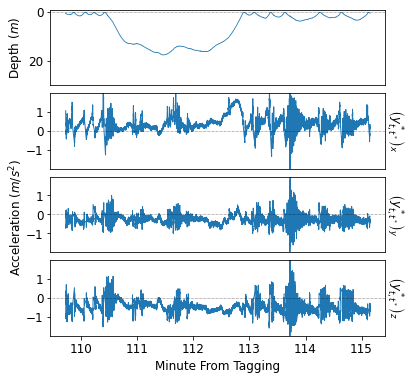

In [30]:
sdive = 140
edive = 150

fig,ax = plt.subplots(4,1,figsize = (6,6))

ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")

temp_df = df[(df['dive_num'] >= sdive) & (df['dive_num'] <= edive)]

plt.subplot(4,1,1)
plt.plot(temp_df['hr_from_start'],temp_df['depth'],linewidth=0.8)
plt.ylim([30,-1])
plt.xticks([])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.ylabel('Depth $(m)$',fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(4,1,2)
ax = plt.gca()
ax.yaxis.set_label_coords(1.06,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_x$',fontsize=12,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Ax'],linewidth=1)
plt.xticks([])
plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-1,0,1],fontsize=12)

plt.subplot(4,1,3)
ax = plt.gca()
ax.yaxis.set_label_coords(1.06,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_y$',fontsize=12,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Ay'],linewidth=1)
plt.xticks([])
plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-1,0,1],fontsize=12)

plt.subplot(4,1,4)
ax = plt.gca()
ax.yaxis.set_label_coords(1.06,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_z$',fontsize=12,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Az'],linewidth=1)
plt.xlabel('Minute From Tagging',fontsize=12)
plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-1,0,1],fontsize=12)
plt.xticks(fontsize=12)

fig.text(0.025, 0.4, 'Acceleration $(m/s^2)$', va='center', rotation='vertical',fontsize=12)
plt.subplots_adjust(wspace=0, hspace=0.1)



plt.savefig('../Plots/%s/%s_%s_%s_%s_raw_data_5_dives' % (year,whale,s_dive,e_dive,model),dpi=500)
plt.show()

del temp_df

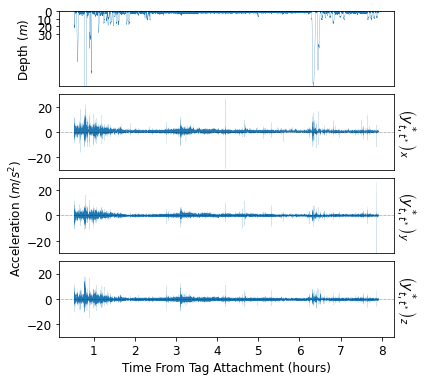

In [31]:
fig,ax = plt.subplots(4,1,figsize = (6,6),sharex=True)
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")

temp_df = df

plt.subplot(4,1,1)
plt.plot(temp_df['hr_from_start'],temp_df['depth'],linewidth=0.25)
#plt.show()
#plt.title('Dive Profile / Accelerometer Data',fontsize=12)
plt.ylim([100,-1])
plt.xticks([])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.ylabel('Depth $(m)$',fontsize=12)
plt.yticks([0,10,20,30],fontsize=12)
#plt.show()

plt.subplot(4,1,2)
ax = plt.gca()
ax.yaxis.set_label_coords(1.07,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_x$',fontsize=14,rotation=270)
plt.plot(temp_df['hr_from_start'],temp_df['Ax'],linewidth=0.1)
plt.xticks([])
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-20,0,20],fontsize=12)

plt.subplot(4,1,3)
ax = plt.gca()
ax.yaxis.set_label_coords(1.07,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_y$',fontsize=14,rotation=270)
plt.plot(temp_df['hr_from_start'],temp_df['Ay'],linewidth=0.1)
plt.xticks([])
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-20,0,20],fontsize=12)

plt.subplot(4,1,4)
ax = plt.gca()
ax.yaxis.set_label_coords(1.07,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_z$',fontsize=14,rotation=270)
plt.plot(temp_df['hr_from_start'],temp_df['Az'],linewidth=0.1)
plt.xlabel('Time From Tag Attachment (hours)',fontsize=12)
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-20,0,20],fontsize=12)
#plt.xticks([0,100,200,300],fontsize=12)

fig.text(0.005, 0.4, 'Acceleration $(m/s^2)$', va='center', rotation='vertical',fontsize=12)

del temp_df
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig('../Plots/%s/%s_%s_%s_%s_raw_data' % (year,whale,s_dive,e_dive,model),dpi=500)
plt.show()

dive_duration
[[ 1.     -0.1007]
 [-0.1007  1.    ]]
Ax
[[1.     0.8833]
 [0.8833 1.    ]]
Ay
[[1.     0.7619]
 [0.7619 1.    ]]
Az
[[1.     0.8646]
 [0.8646 1.    ]]
Ahat_low
[[1.     0.6732]
 [0.6732 1.    ]]


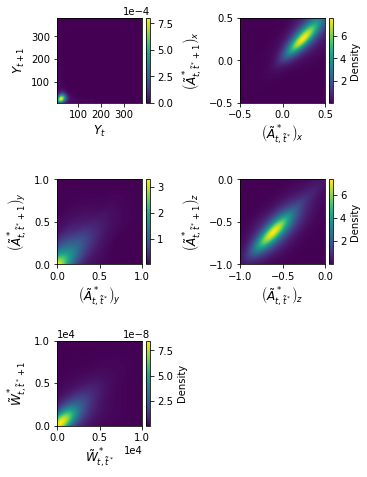

In [32]:
importlib.reload(Visualisor)
viz = Visualisor.Visualisor(pars,data,df)
viz.lagplot(lims={'peak_jerk':[0,50],
                  'roll_at_pj':[0,1],
                  'heading_var':[0,0.2],
                  'Ahat_low':[0,10000],
                  'FoVeDBA_high':[0,10],
                  'Vz':[-5,5],
                  'Ax':[-0.5,0.5],
                  'Ay':[0,1.0],
                  'Az':[-1.0,0.0]},
           file = '../Plots/%s/%s_%s_%s_%s_lagplot.png' % (year,whale,s_dive,e_dive,model))

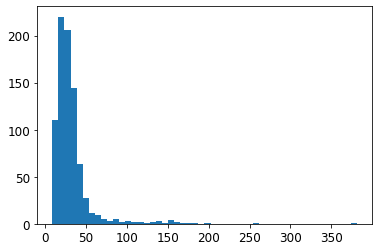

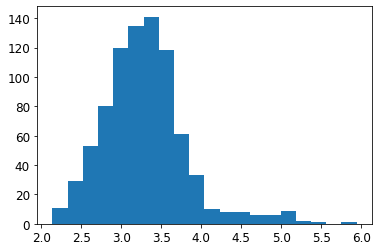

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning:

Pass n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



[[7.5879]
 [4.3035]]
[[[1.1678]]

 [[0.7701]]]
[0.5988 0.4012]


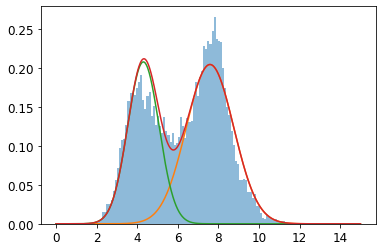

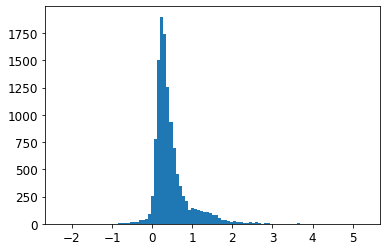

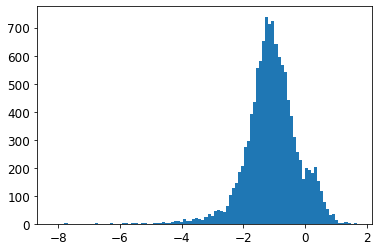

In [33]:
# plot dive duration
plt.hist([datum['dive_duration'] for datum in data],bins=50)
plt.show()

plt.hist([np.log(datum['dive_duration']) for datum in data],bins=20)
plt.show()

# get ahat and acceleration
ahat = []
acc = []
for datum in data:
    for seg in datum['subdive_features']:
        acc.append(seg['Ax'])
        ahat.append(np.log(seg['Ahat_low']))
    
# plot ahat
plt.hist(ahat,bins=100,alpha = 0.5,density=True)
n=2
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture
GM = BayesianGaussianMixture(n,max_iter=10,n_init=10)
GM.fit(np.array(ahat).reshape(-1, 1))
print(GM.means_)
print(GM.covariances_)
print(GM.weights_)
x = np.linspace(0,15,1000)
total = np.zeros_like(x)
for i in range(n):
    plt.plot(x,norm.pdf(x,loc=GM.means_[i][0],scale=GM.covariances_[i,0,0])*GM.weights_[i]/np.sum(GM.weights_))
    total += norm.pdf(x,loc=GM.means_[i][0],scale=GM.covariances_[i,0,0])*GM.weights_[i]
plt.plot(x,total/np.sum(GM.weights_))
plt.show()
    
# plot acceleration
plt.hist(acc,bins=100)
plt.show()

# plot acceleration
plt.hist([np.log(np.abs(x)) for x in acc],bins=100)
plt.show()

# Train HHMM

In [35]:
deep_data = [data[i] for i in range(s_dive,e_dive)]
importlib.reload(HHMM)
hhmm = HHMM.HHMM(pars,deep_data)

# load model
try:
    hhmm = hhmm.load(HHMM_file)
except:
    print('No existing HMM model')

stime = time.time()

if train_new:
    print('Training new model')
    hhmm.train_DM(deep_data,max_steps=1,max_iters=5)
    
    h = 0.01
    hhmm.get_SEs(deep_data,h)

    hhmm.save(HHMM_file)

No existing HMM model
Training new model
ITERATION 0
-110194.80217654962

updated coarse eta, row 0
original:  [ 0.     -0.9078]
new:  [-0.3361]
-110188.5005820746
updated coarse eta, row 1
original:  [-0.9624  0.    ]
new:  [-0.9997]
-110188.47394299641
updated coarse theta dive_duration, state 0, param mu
original:  19.604999899864197
new:  [24.9964]
-110132.3389030705
updated coarse theta dive_duration, state 0, param sig
original:  4.475985610567275
new:  [7.3854]
-110088.93688214486
updated coarse theta dive_duration, state 1, param mu
original:  34.58499991893768
new:  [44.0959]
-110050.25129069189
updated coarse theta dive_duration, state 1, param sig
original:  33.75043497874919
new:  [30.3754]
-110045.43181322739
updated fine eta, dive 0, row 0
original:  [ 0.     -0.8674 -1.0695]
new:  [-1.8105 -1.1556]
-110012.8714774764
updated fine eta, dive 0, row 1
original:  [-1.015   0.     -0.8151]
new:  [-1.4528 -1.9205]
-109967.1671277254
updated fine eta, dive 0, row 2
original:  [

KeyboardInterrupt: 

In [ ]:
print(hhmm.likelihood(deep_data))
print(time.time() - stime)
data,df = hhmm.label_df(data,df)

# Visualize Results

In [ ]:
fig = plt.figure(figsize = (5,7.5))

gs = GridSpec(3,2)

ax1=fig.add_subplot(gs[0,:])
ax2=fig.add_subplot(gs[1,0])
ax3=fig.add_subplot(gs[1,1])
ax4=fig.add_subplot(gs[2,0])
ax5=fig.add_subplot(gs[2,1])

axs = [ax2,ax3,ax4,ax5]

# Coarse Scale
            
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']

dist = pars.features[0]['dive_duration']['f']
K = pars.K[0]
colors = [cm.get_cmap('tab10')(i) for i in [0,1]]
legend = ['Dive Type %d'%(x+1) for x in range(K)]

for state in range(K):
    if dist == 'gamma':
        shape = np.square(mu)/np.square(sig)
        scale = np.square(sig)/np.array(mu)
        x = np.linspace(0.01,max(mu)+5*max(sig),100000)
        y = gamma.pdf(x,shape[state],0,scale[state])
    elif dist == 'normal':
        x = np.linspace(min(mu)-3*max(sig),max(mu)+3*max(sig),100000)
        y = norm.pdf(x,mu[state],sig[state])
    elif dist == 'vonmises':
        x = np.linspace(-np.pi,np.pi,100000)
        y = vonmises.pdf(x,sig[state],loc=mu[state])
    else:
        raise('distribution %s not recognized' % dist)
    ax1.plot(x,y,color=colors[state])
    ax1.set_ylabel('Density',fontsize=12)
    ax1.set_xlabel('$Y_t$ $(s)$')
    
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Dive 1',
                       markerfacecolor=colors[0], markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Dive 2',
                       markerfacecolor=colors[1], markersize=8)]

fig.legend(handles=legend_elements,
           prop={'size': 10}, ncol=2,
           mode='expand',
           bbox_to_anchor=(0.1, 0.975, 0.9, 0.5),
           loc='lower left')

fine_features=['Ax','Ay','Az','Ahat_low']

# fine scale
for feature_num,feature in enumerate(fine_features):

    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']

    dist = pars.features[1][feature]['f']
    K = pars.K[1]
    colors = [cm.get_cmap('viridis')(i) for i in [0.,0.5,1.]]
    legend = ['Subdive State %d'%(x+1) for x in range(K)]

    for state in range(K):
        if dist == 'gamma':
            shape = np.square(mu)/np.square(sig)
            scale = np.square(sig)/np.array(mu)
            x = np.linspace(0.01,max(mu)+5*max(sig),100000)
            y = gamma.pdf(x,shape[state],0,scale[state])
        elif dist == 'normal':
            x = np.linspace(min(mu)-3*max(sig),max(mu)+3*max(sig),100000)
            y = norm.pdf(x,mu[state],sig[state])
        elif dist == 'vonmises':
            x = np.linspace(-np.pi,np.pi,100000)
            y = vonmises.pdf(x,sig[state],loc=mu[state])
        else:
            raise('distribution %s not recognized' % dist)
        axs[feature_num].plot(x,y,color=colors[state])
        if feature_num%2 == 0:
            axs[feature_num].set_ylabel('Density',fontsize=12)
        titles = [r'$\left(\tilde A^*_{t,\tilde t^*}\right)_x$ $(m/s^2)$',
                  r'$\left(\tilde A^*_{t,\tilde t^*}\right)_y$ $(m/s^2)$',
                  r'$\left(\tilde A^*_{t,\tilde t^*}\right)_z$ $(m/s^2)$',
                  r'$\tilde W^*_{t,\tilde t^*}$']
        title = titles[feature_num]
        axs[feature_num].set_xlabel(title,fontsize=12)
        if feature == 'Ahat_low':
            axs[feature_num].set_xscale('log')
            axs[feature_num].set_yscale('log')
            axs[feature_num].set_ylim([10e-8,10e-1])
            axs[feature_num].set_xlim([10e-1,10e4])

        legend_elements = [Line2D([0], [0], marker='o', color='w', label='Subdive 1',
                               markerfacecolor=colors[0], markersize=8),
                           Line2D([0], [0], marker='o', color='w', label='Subdive 2',
                               markerfacecolor=colors[1], markersize=8),
                           Line2D([0], [0], marker='o', color='w', label='Subdive 3',
                               markerfacecolor=colors[2], markersize=8)]

        fig.legend(handles=legend_elements,
                   prop={'size': 10}, ncol=3,
                   mode='expand',
                   bbox_to_anchor=(0.1, 0.65, 0.9, 0.5),
                   loc='lower left')

plt.tight_layout()
bbox = Bbox([[0,0],[5,8]])
file = '../Plots/%s/%s_%s_%s_%s_all_emissions.png' % (year,whale,s_dive,e_dive,model)
plt.savefig(file,bbox_inches=bbox,dpi=500)
plt.show()

In [ ]:
print(hhmm.likelihood(deep_data))

sdive = 160
edive = 165

importlib.reload(Visualisor)
viz = Visualisor.Visualisor(pars,data,df)
viz.hhmm = hhmm
#rcParams.update({'figure.autolayout': True})
viz.plot_emission_probs(0,file='../Plots/%s/%s_%s_%s_%s-coarse-emissions.png'%(year,whale,s_dive,e_dive,model))
if model == 'CarHHMM1':
    viz.plot_emission_probs(1,
                            file='../Plots/%s/%s_%s_%s_%s-fine-emissions.png' % (year,whale,s_dive,e_dive,model),
                            features=['Ax','Ay','Az'])
else:
    viz.plot_emission_probs(1,file='../Plots/%s/%s_%s_%s_%s-fine-emissions.png' % (year,whale,s_dive,e_dive,model))
viz.print_ptms()
if model != 'CarHMM':
    viz.plot_dive_features(sdive,edive,['dive_state_0_prob',
                                    'dive_state_1_prob',
                                    'subdive_state_0_prob',
                                    'subdive_state_1_prob',
                                    'subdive_state_2_prob'],[],
                           file = '../Plots/%s/%s_%s_%s_%s_decoded_states.png' % (year,whale,s_dive,e_dive,model),
                           nrows = 5)
else:
    viz.plot_dive_features(sdive,edive,['dive_state_0_prob',
                                    'subdive_state_0_prob',
                                    'subdive_state_1_prob',
                                    'subdive_state_2_prob'],[],
                           ylabs = [r'$Pr\left(X_t = 1\right)$',
                                    r'$Pr\left(\tilde X^*_{t,\tilde t^*} = 1\right)$',
                                    r'$Pr\left(\tilde X^*_{t,\tilde t^*} = 2\right)$',
                                    r'$Pr\left(\tilde X^*_{t,\tilde t^*} = 3\right)$'],
                           file = '../Plots/%s/%s_%s_%s_%s_decoded_states.png' % (year,whale,s_dive,e_dive,model),
                           nrows = 4)
    
plt.show()

viz.plot_dive_features(sdive,edive,['Ax','depth'],[],
                       file = '../Plots/%s/%s_%s_%s_%s_decoded_dives.png' % (year,whale,s_dive,e_dive,model),
                       ylabs = [r'$\left(y^*_{t,t^*}\right)_x$ $(m/s^2)$',r'Depth $(m)$'],
                       nrows = 4)

# Histograms over emission distributions

In [ ]:
# colors
dive_colors = [cm.get_cmap('tab10')(0),
               cm.get_cmap('tab10')(1)]
subdive_colors = [cm.get_cmap('viridis')(0),
                  cm.get_cmap('viridis')(0.5),
                  cm.get_cmap('viridis')(1.0)]

# dive duration
weights = [list([]),list([])]
values = []

for dive in data:
    weights[0].append(dive['dive_state_probs'][0])
    if model != 'CarHMM':
        weights[1].append(dive['dive_state_probs'][1])
    values.append(dive['dive_duration'])
        
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)

plt.figure(figsize=(3,3))
for state in range(hhmm.pars.K[0]):
    bins = np.linspace(0.01,mu[state]+5*sig[state],25)
    x = np.linspace(0.01,mu[state]+5*sig[state],10000)
    y = gamma.pdf(x,shape[state],0,scale[state])
    plt.hist(values,weights=weights[state],density=True,bins=bins,color=dive_colors[state],alpha=0.5)
    plt.plot(x,y,color=dive_colors[state],linewidth=2)

if model != 'CarHMM':
    plt.legend(['Dive Type 1','Dive Type 2'],fontsize=10)
for state in range(hhmm.pars.K[0]):
    x = np.linspace(0.01,mu[state]+5*sig[state],10000)
    y = gamma.pdf(x,shape[state],0,scale[state])
    plt.plot(x,y,color='k',linewidth=1)
plt.title('$Y_t$, All Dive Types')
plt.ylabel('Density')
plt.xlabel('Dive Duration $(s)$')
plt.tight_layout()
plt.savefig('../Plots/%s/%s_%s_%s_%s_empirical_hist_dive_duration.png' % (year,whale,s_dive,e_dive,model),
            dpi=500)
plt.show()
    
# A-hat
if model != 'CarHHMM1':
    weights = [list([]),list([]),list([])]
    values = []

    for dive in data:
        for seg in dive['subdive_features']:
            weights[0].append(seg['subdive_state_probs'][0])
            weights[1].append(seg['subdive_state_probs'][1])
            weights[2].append(seg['subdive_state_probs'][2])
            values.append(seg['Ahat_low'])

    mu = hhmm.theta[1][0]['Ahat_low']['mu']
    sig = hhmm.theta[1][0]['Ahat_low']['sig']
    shape = np.square(mu)/np.square(sig)
    scale = np.square(sig)/np.array(mu)
    for state in range(hhmm.pars.K[1]):
        plt.figure(figsize=(3,3))
        bins = np.linspace(0.01,mu[state]+5*sig[state],100)
        plt.hist(values,weights=weights[state],density=True,bins=bins,color=subdive_colors[state],alpha=0.5)
        xlim = plt.gca().get_xlim()
        ylim = plt.gca().get_ylim()
        x = np.linspace(0.01,mu[state]+5*sig[state],10000)
        y = gamma.pdf(x,shape[state],0,scale[state])
        plt.plot(x,y,color='k',linewidth=1)
        plt.title(r'$\tilde W^*_{t,\tilde t^*}$, Subdive State %d'%(state+1))
        plt.xlim(xlim)
        plt.xlabel('Wiggliness')
        plt.ylim(ylim)
        plt.ylabel('Density')
        #plt.legend(['Fit Distribution','Empirical Histogram'],fontsize=12)
        plt.hist(values,weights=weights[state],density=True,bins=bins,color='k',alpha=0.1)
        plt.plot(x,y,color=subdive_colors[state],linewidth=2)
        plt.plot(x,y,color='k',linewidth=1)
        plt.tight_layout()
        plt.savefig('../Plots/%s/%s_%s_%s_%s_empirical_hist_ahat_%d.png' % (year,whale,s_dive,e_dive,model,state),
            dpi=500)
        plt.show()
    
    
# Ax
for feature in ['Ax','Ay','Az']:
    print(feature)
    weights = [list([]),list([]),list([])]
    values = [list([]),list([]),list([])]

    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']
    corr = expit(hhmm.theta[1][0][feature]['corr'])

    for state in range(hhmm.pars.K[1]):
        for dive in data:
            seg_tm1 = dive['subdive_features'][0]
            for seg in dive['subdive_features'][1:]:
                weights[state].append(seg['subdive_state_probs'][state])
                values[state].append(seg[feature] - (corr[state]*seg_tm1[feature] + (1.0-corr[state])*mu[state]))
                seg_tm1 = seg
                
    for state in range(hhmm.pars.K[1]):
        plt.figure(figsize=(3,3))
        bins = np.linspace(-5*sig[state],5*sig[state],100)
        plt.hist(values[state],weights=weights[state],density=True,bins=bins,
                 color=subdive_colors[state],alpha=0.5)
        x = np.linspace(-5*sig[state],5*sig[state],10000)
        y = norm.pdf(x,0,sig[state])
        plt.plot(x,y,color=subdive_colors[state],linewidth=2)
        plt.ylabel('Density')
        plt.xlabel('$\Delta \mathbf{a}_%s \enspace (m/s^2)$'%feature[-1])
        plt.title(r'$\left(\tilde A^*_{t,\tilde t^*}\right)_%s$, Subdive State %d'%(feature[-1],state+1))
        #plt.legend(['Fit Distribution','Empirical Histogram'],fontsize=12)
        plt.plot(x,y,color='k',linewidth=1)
        plt.hist(values[state],weights=weights[state],density=True,bins=bins,
                 color='k',alpha=0.1)
        plt.tight_layout()
        plt.savefig('../Plots/%s/%s_%s_%s_%s_empirical_hist_%s_%d' % (year,whale,s_dive,e_dive,model,feature,state),
                    dpi=500)
        plt.show()

# Psuedoresiduals

In [ ]:
x = np.linspace(-5,5,1000)
y = norm.pdf(x)

# dive duration
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)

psuedoresids = []

for dive in data:
    cdf = 0
    for state in range(hhmm.pars.K[0]):
        cdf += dive['dive_state_probs'][state] * \
               gamma.cdf(dive['dive_duration'],
                         shape[state],0,scale[state])
    if cdf >= 1.0:
        cdf = 0.9999
        
    psuedoresids.append(norm.ppf(cdf))

plt.figure(figsize=(3,3))
plt.hist(psuedoresids,density=True,bins=20,color='k',alpha=0.5)
plt.title('$Y_t$ (Dive Duration)')
plt.plot(x,y,color='k',linewidth=1)
plt.xlabel('Pseudoresiduals')
plt.ylabel('Density')
#plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=12)
plt.tight_layout()
plt.savefig('../Plots/%s/%s_%s_%s_%s_pseudresids_dive_duration.png' % (year,whale,s_dive,e_dive,model),dpi=500)
plt.show()

# A-hat
if model != 'CarHHMM1':
    mu = hhmm.theta[1][0]['Ahat_low']['mu']
    sig = hhmm.theta[1][0]['Ahat_low']['sig']
    shape = np.square(mu)/np.square(sig)
    scale = np.square(sig)/np.array(mu)

    psuedoresids = []

    for dive in data:
        for seg in dive['subdive_features']:
            cdf = 0
            for state in range(hhmm.pars.K[1]):
                cdf += seg['subdive_state_probs'][state] * \
                        gamma.cdf(seg['Ahat_low'],shape[state],0,scale[state])
            if cdf >= 1.0:
                cdf = 0.9999
            psuedoresids.append(norm.ppf(cdf))

    plt.figure(figsize=(3,3))     
    plt.hist(psuedoresids,density=True,bins=50,color='k',alpha=0.5)
    plt.title(r'$\tilde W^*_{t,\tilde t^*}$ (Wiggliness)')
    plt.plot(x,y,color='k',linewidth=1)
    plt.xlabel('Pseudoresiduals')
    plt.ylabel('Density')
    #plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=12)
    plt.tight_layout()
    plt.savefig('../Plots/%s/%s_%s_%s_%s_pseudresids_ahat.png' % (year,whale,s_dive,e_dive,model),dpi=500)
    plt.show() 

for feature in ['Ax','Ay','Az']:
    print(feature)
    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']
    corr = expit(hhmm.theta[1][0][feature]['corr'])
    
    psuedoresids = []

    for state in range(hhmm.pars.K[1]):
        for dive in data:
            seg_tm1 = dive['subdive_features'][0]
            for seg in dive['subdive_features'][1:]:
                cdf = 0
                for state in range(hhmm.pars.K[1]):
                    mean = corr[state]*seg_tm1[feature] + (1.0-corr[state])*mu[state]
                    cdf += seg['subdive_state_probs'][state] * \
                            norm.cdf(seg[feature],mean,sig[state])
                seg_tm1 = seg
                if cdf >= 1.0:
                    cdf = 0.9999
                psuedoresids.append(norm.ppf(cdf))
                
    plt.figure(figsize=(3,3))
    plt.hist(psuedoresids,density=True,bins=50,color='k',alpha=0.5)
    plt.plot(x,y,color='k',linewidth=0.5)
    plt.title(r'$\left(\tilde A^*_{t,\tilde t^*}\right)_%s$ (Avg Acceleration)'%feature[-1])
    plt.xlabel('Pseudoresiduals')
    plt.ylabel('Density')
    #plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=10)
    plt.tight_layout()
    plt.savefig('../Plots/%s/%s_%s_%s_%s_pseudresids_%s.png' % (year,whale,s_dive,e_dive,model,feature),dpi=500)
    plt.show()   

# Make Tables

In [ ]:
if model == 'CarHHMM2':
    table = r'''
    \begin{table}[h!]
    \centering
    \label{table:emis_dists}
    \caption{Estimates and standard errors of parameters for killer whale data.}
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}              \\
                                                                                   &                                      & $\hat \mu$      & $\hat \sigma$   & $\hat \phi$     \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ - $Y$}                                     & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{x-acceleration $(m/s^2)$ - $\tilde A^*_x$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{y-acceleration $(m/s^2)$ - $\tilde A^*_y$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{z-acceleration $(m/s^2)$ - $\tilde A^*_z$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{Fourier sum - $\tilde W^*$}                                           & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \end{tabular}
    \end{table}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
           hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           expit(hhmm.theta[1][0]['Ax']['corr'][0]),hhmm.SEs['Ax']['corr'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           expit(hhmm.theta[1][0]['Ax']['corr'][1]),hhmm.SEs['Ax']['corr'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           expit(hhmm.theta[1][0]['Ax']['corr'][2]),hhmm.SEs['Ax']['corr'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           expit(hhmm.theta[1][0]['Ay']['corr'][0]),hhmm.SEs['Ay']['corr'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           expit(hhmm.theta[1][0]['Ay']['corr'][1]),hhmm.SEs['Ay']['corr'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           expit(hhmm.theta[1][0]['Ay']['corr'][2]),hhmm.SEs['Ay']['corr'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           expit(hhmm.theta[1][0]['Az']['corr'][0]),hhmm.SEs['Az']['corr'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           expit(hhmm.theta[1][0]['Az']['corr'][1]),hhmm.SEs['Az']['corr'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           expit(hhmm.theta[1][0]['Az']['corr'][2]),hhmm.SEs['Az']['corr'][2],
           hhmm.theta[1][0]['Ahat_low']['mu'][0],hhmm.SEs['Ahat_low']['mu'][0],
           hhmm.theta[1][0]['Ahat_low']['sig'][0],hhmm.SEs['Ahat_low']['sig'][0],
           hhmm.theta[1][0]['Ahat_low']['mu'][1],hhmm.SEs['Ahat_low']['mu'][1],
           hhmm.theta[1][0]['Ahat_low']['sig'][1],hhmm.SEs['Ahat_low']['sig'][1],
           hhmm.theta[1][0]['Ahat_low']['mu'][2],hhmm.SEs['Ahat_low']['mu'][2],
           hhmm.theta[1][0]['Ahat_low']['sig'][2],hhmm.SEs['Ahat_low']['sig'][2])

    print(table)
    
elif model == 'CarHHMM1':
    
    table = r'''
    \begin{table}[h!]
    \centering
    \label{table:emis_dists}
    \caption{Estimates and standard errors of parameters for killer whale data.}
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}              \\
                                                                                   &                                      & $\hat \mu$      & $\hat \sigma$   & $\hat \phi$     \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ - $Y$}                                     & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{x-acceleration $(m/s^2)$ - $\tilde A^*_x$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{y-acceleration $(m/s^2)$ - $\tilde A^*_y$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{z-acceleration $(m/s^2)$ - $\tilde A^*_z$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \end{tabular}
    \end{table}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
           hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           expit(hhmm.theta[1][0]['Ax']['corr'][0]),hhmm.SEs['Ax']['corr'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           expit(hhmm.theta[1][0]['Ax']['corr'][1]),hhmm.SEs['Ax']['corr'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           expit(hhmm.theta[1][0]['Ax']['corr'][2]),hhmm.SEs['Ax']['corr'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           expit(hhmm.theta[1][0]['Ay']['corr'][0]),hhmm.SEs['Ay']['corr'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           expit(hhmm.theta[1][0]['Ay']['corr'][1]),hhmm.SEs['Ay']['corr'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           expit(hhmm.theta[1][0]['Ay']['corr'][2]),hhmm.SEs['Ay']['corr'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           expit(hhmm.theta[1][0]['Az']['corr'][0]),hhmm.SEs['Az']['corr'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           expit(hhmm.theta[1][0]['Az']['corr'][1]),hhmm.SEs['Az']['corr'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           expit(hhmm.theta[1][0]['Az']['corr'][2]),hhmm.SEs['Az']['corr'][2])

    print(table)
    
elif model == 'HHMM':
    
    table = r'''
    \begin{table}[h!]
    \centering
    \label{table:emis_dists}
    \caption{Estimates and standard errors of parameters for killer whale data.}
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}              \\
                                                                                   &                                      & $\hat \mu$      & $\hat \sigma$   & $\hat \phi$     \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ - $Y$}                                     & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{x-acceleration $(m/s^2)$ - $\tilde A^*_x$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{y-acceleration $(m/s^2)$ - $\tilde A^*_y$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{z-acceleration $(m/s^2)$ - $\tilde A^*_z$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{Wiggliness - $\tilde W^*$}                                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \end{tabular}
    \end{table}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
           hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           hhmm.theta[1][0]['Ahat_low']['mu'][0],hhmm.SEs['Ahat_low']['mu'][0],
           hhmm.theta[1][0]['Ahat_low']['sig'][0],hhmm.SEs['Ahat_low']['sig'][0],
           hhmm.theta[1][0]['Ahat_low']['mu'][1],hhmm.SEs['Ahat_low']['mu'][1],
           hhmm.theta[1][0]['Ahat_low']['sig'][1],hhmm.SEs['Ahat_low']['sig'][1],
           hhmm.theta[1][0]['Ahat_low']['mu'][2],hhmm.SEs['Ahat_low']['mu'][2],
           hhmm.theta[1][0]['Ahat_low']['sig'][2],hhmm.SEs['Ahat_low']['sig'][2])

    print(table)
    
elif model == 'CarHMM':
    
    table = r'''
    \begin{table}[h!]
    \centering
    \label{table:emis_dists}
    \caption{Estimates and standard errors of parameters for killer whale data.}
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}              \\
                                                                                   &                                      & $\hat \mu$      & $\hat \sigma$   & $\hat \phi$     \\ \hline
    \multirow{1}{*}{Dive Duration $(s)$ - $Y$}                                     & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{x-acceleration $(m/s^2)$ - $\tilde A^*_x$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{y-acceleration $(m/s^2)$ - $\tilde A^*_y$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{z-acceleration $(m/s^2)$ - $\tilde A^*_z$}                            & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{Fourier sum - $\tilde W^*$}                                           & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \end{tabular}
    \end{table}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           expit(hhmm.theta[1][0]['Ax']['corr'][0]),hhmm.SEs['Ax']['corr'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           expit(hhmm.theta[1][0]['Ax']['corr'][1]),hhmm.SEs['Ax']['corr'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           expit(hhmm.theta[1][0]['Ax']['corr'][2]),hhmm.SEs['Ax']['corr'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           expit(hhmm.theta[1][0]['Ay']['corr'][0]),hhmm.SEs['Ay']['corr'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           expit(hhmm.theta[1][0]['Ay']['corr'][1]),hhmm.SEs['Ay']['corr'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           expit(hhmm.theta[1][0]['Ay']['corr'][2]),hhmm.SEs['Ay']['corr'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           expit(hhmm.theta[1][0]['Az']['corr'][0]),hhmm.SEs['Az']['corr'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           expit(hhmm.theta[1][0]['Az']['corr'][1]),hhmm.SEs['Az']['corr'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           expit(hhmm.theta[1][0]['Az']['corr'][2]),hhmm.SEs['Az']['corr'][2],
           hhmm.theta[1][0]['Ahat_low']['mu'][0],hhmm.SEs['Ahat_low']['mu'][0],
           hhmm.theta[1][0]['Ahat_low']['sig'][0],hhmm.SEs['Ahat_low']['sig'][0],
           hhmm.theta[1][0]['Ahat_low']['mu'][1],hhmm.SEs['Ahat_low']['mu'][1],
           hhmm.theta[1][0]['Ahat_low']['sig'][1],hhmm.SEs['Ahat_low']['sig'][1],
           hhmm.theta[1][0]['Ahat_low']['mu'][2],hhmm.SEs['Ahat_low']['mu'][2],
           hhmm.theta[1][0]['Ahat_low']['sig'][2],hhmm.SEs['Ahat_low']['sig'][2])

    print(table)

In [ ]:
if model != 'CarHMM':
    ptm = HHMM.eta_2_ptm(hhmm.eta[0])
    delta = np.array([0.5,0.5])
    for _ in range(100):
        delta = delta.dot(ptm)

    gamma0 = r'''$$\hat \Gamma = \begin{pmatrix} 
    %.3f & %.3f \\
    %.3f & %.3f
    \end{pmatrix}$$
    $$\hat \delta = \begin{pmatrix} %.3f & %.3f \end{pmatrix}$$
    '''% tuple(np.concatenate([ptm.flatten(),delta]))

    print(gamma0)

In [ ]:
ptm1 = HHMM.eta_2_ptm(hhmm.eta[1][0])
delta1 = np.array([0.3333,0.3333,0.3334])
for _ in range(100):
    delta1 = delta1.dot(ptm1)
    
if model != 'CarHMM':
    
    ptm2 = HHMM.eta_2_ptm(hhmm.eta[1][1])
    delta2 = np.array([0.3333,0.3333,0.3334])
    for _ in range(100):
        delta2 = delta2.dot(ptm2)

    gamma0 = r'''$$\hat \Gamma^{*(1)} = \begin{pmatrix} 
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f
    \end{pmatrix}$$
    $$\hat \delta^{*(1)} = \begin{pmatrix} %.3f & %.3f & %.3f \end{pmatrix}$$

    $$\hat \Gamma^{*(2)} = \begin{pmatrix} 
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f
    \end{pmatrix}$$
    $$\hat \delta^{*(2)} = \begin{pmatrix} %.3f & %.3f & %.3f \end{pmatrix}$$
    ''' % tuple(np.concatenate([ptm1.flatten(),delta1,ptm2.flatten(),delta2]))
    
else:
    
    gamma0 = r'''$$\hat \Gamma^{*(1)} = \begin{pmatrix} 
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f
    \end{pmatrix}$$
    $$\hat \delta^{*(1)} = \begin{pmatrix} %.3f & %.3f & %.3f \end{pmatrix}$$
    ''' % tuple(np.concatenate([ptm1.flatten(),delta1]))
    
print(gamma0)

# Check Autocorrelation within states

In [ ]:
Ax_t = [[] for _ in range(3)]
Ax_tp1 = [[] for _ in range(3)]
Ay_t = [[] for _ in range(3)]
Ay_tp1 = [[] for _ in range(3)]
Az_t = [[] for _ in range(3)]
Az_tp1 = [[] for _ in range(3)]

for dive in data:
    seg_type_t = -1
    ax_tm1 = 0
    ay_tm1 = 0
    az_tm1 = 0
    for seg in dive['subdive_features']:
        seg_type_tp1 = np.argmax(seg['subdive_state_probs'])
        if seg_type_tp1 == seg_type_t:
            
            Ax_t[seg_type_t].append(ax_tm1)
            Ay_t[seg_type_t].append(ay_tm1)
            Az_t[seg_type_t].append(az_tm1)
            
            Ax_tp1[seg_type_t].append(seg['Ax'])
            Ay_tp1[seg_type_t].append(seg['Ay'])
            Az_tp1[seg_type_t].append(seg['Az'])
        
        ax_tm1 = seg['Ax']
        ay_tm1 = seg['Ay']
        az_tm1 = seg['Az']
        
        seg_type_t = seg_type_tp1

i = 0
print(np.corrcoef(Ax_t[i],Ax_tp1[i]))
print(np.corrcoef(Ay_t[i],Ay_tp1[i]))
print(np.corrcoef(Az_t[i],Az_tp1[i]))
print('')
i += 1
print(np.corrcoef(Ax_t[i],Ax_tp1[i]))
print(np.corrcoef(Ay_t[i],Ay_tp1[i]))
print(np.corrcoef(Az_t[i],Az_tp1[i]))
print('')
i += 1
print(np.corrcoef(Ax_t[i],Ax_tp1[i]))
print(np.corrcoef(Ay_t[i],Ay_tp1[i]))
print(np.corrcoef(Az_t[i],Az_tp1[i]))

In [36]:
#h = 0.01

#print(hhmm.likelihood(data))
#hhmm.eta[1][0][0,1] += h
#print(hhmm.likelihood(data))
#hhmm.eta[1][0][0,1] += -2*h
#print(hhmm.likelihood(data))
#hhmm.eta[1][0][0,1] += h
#print(hhmm.likelihood(data))

In [27]:
#h = 0.95
#print(hhmm.likelihood(data))
#hhmm.theta[1][0]['Ax']['corr'][2] = h
#hhmm.theta[1][1]['Ax']['corr'][2] = h
#hhmm.theta[1][0]['Ay']['corr'][2] = h
#hhmm.theta[1][1]['Ay']['corr'][2] = h
#hhmm.theta[1][0]['Az']['corr'][2] = h
#hhmm.theta[1][1]['Az']['corr'][2] = h
#print(hhmm.likelihood(data))

In [28]:
#hhmm.theta[1][0]['Ax']['corr'][2]

In [ ]:
#hhmm.save(HHMM_file)

In [ ]:
#np.argmax(data[1]['subdive_features'][0]['subdive_state_probs'])

In [ ]:
#ethogram_file = '../../../PHMM/Dat/ethograms/A113_ethogram_Nov_10_2020.csv'
#ethogram = pd.read_csv(ethogram_file,encoding='cp1252')

#ethogram['time'] = pd.to_datetime('2020-08-22 ' + ethogram['event.time'],
                                   format = '%Y-%m-%d 00:%H:%M:%S',
                                   errors = 'coerce')

In [ ]:
#print(df['time'].min())
#print(df['time'].max())
#print(ethogram['time'].min())
#print(ethogram['time'].max())

In [ ]:
'''
fig,ax = plt.subplots(16,1,figsize = (40,96))

df['roll'] = df['roll'] - df['roll'].mean()

temp_df = df[(df['dive_num'] >= 107) & (df['dive_num'] <= 107)]

ylabels = ['Depth (m)',
           'acc x (m/s^2)','acc y (m/s^2)','acc z (m/s^2)',
           'mag x','mag y','mag z',
           'gyro x','gyro y','gyro z',
           'roll','pitch','yaw',
           'press','temp','pitot speed']

for i,col in enumerate(['elevation',
                        'Ax','Ay','Az',
                        'Mx','My','Mz',
                        'gyro x','gyro y','gyro z',
                        'roll','pitch','yaw',
                        'press','temp','pitot speed']):
    
    plt.subplot(16,1,i+1)
    plt.ylabel(col,fontsize=30)
    plt.plot(temp_df['sec_from_start'],temp_df[col],linewidth=1)
    plt.ylabel(ylabels[i],fontsize=36)
    plt.yticks(fontsize=30)
    ''
    plt.axvline(2.694*3600,color='k',linestyle=':')
    plt.axvline(2.696*3600,color='k',linestyle=':')
    plt.axvline(8345,color='k',linestyle=':')
    plt.axvline(8347,color='k',linestyle=':')
    plt.axvline(8868,color='k',linestyle=':')
    plt.axvline(8876,color='k',linestyle=':')
    plt.axvline(8868,color='k',linestyle=':')
    plt.axvline(8876,color='k',linestyle=':')
    plt.axvline(9209,color='k',linestyle=':')
    plt.axvline(9212,color='k',linestyle=':')
    plt.axvline(4673,color='k',linestyle=':')
    plt.axvline(4678,color='k',linestyle=':')
    ''

    
plt.xlabel('second from start')
print(temp_df['time'].iloc[0])
print(temp_df['time'].iloc[-1])
#plt.savefig('BIG_data_%s_%s.png'%(temp_df['time'].iloc[0],temp_df['time'].iloc[-1]))
plt.show()
'''